In [1]:
# importing the packages
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
import sklearn.exceptions
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from imblearn.under_sampling import NearMiss 
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)


from numpy import asarray
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [2]:
data_train = pd.read_csv("fraudTrain.csv")
data_test = pd.read_csv("fraudTest.csv")
# taking smaller sample to run the model faster

df_train= data_train.sample(frac = 0.1,random_state=1)
df_test= data_test.sample(frac = 0.05,random_state=1)
print(df_train.shape,df_test.shape)

(129668, 23) (27786, 23)


In [ ]:
#df_test = df_test.drop(['city','state','zip'],axis =1)

In [ ]:
#df_train['add'] = df_train['city'] + df_train['state'] + df_train['zip'].astype(str)

In [ ]:
#df_test['add'] = df_test['city'] + df_test['state'] + df_test['zip'].astype(str)

In [ ]:
#df_test

In [3]:
def getdatafiles():
    # loading data
    data_train = pd.read_csv("fraudTrain.csv")
    data_test = pd.read_csv("fraudTest.csv")
    # taking smaller sample to run the model faster

    df_train= data_train.sample(frac = 0.1,random_state=1)
    df_test= data_test.sample(frac = 0.05,random_state=1)
    print(df_train.shape,df_test.shape)
    
    # function to drop tbe columns
    def dropCol(data):
        col_to_drop = ['trans_date_trans_time','Unnamed: 0',
                       'cc_num','first','last','trans_num','street',
                      'trans_date_trans_time','unix_time']
        res = data.drop(col_to_drop,axis = 1)
        return res
    # dropping the columns
    # dropping the columns ['trans_date_trans_time','Unnamed: 0','cc_num','first','last','trans_num']
    # train data set
    df_train = dropCol(df_train)
    # test data set
    df_test = dropCol(df_test)
    
    # creating a new feature address
    df_train['add'] = df_train['city'] + df_train['state'] + df_train['zip'].astype(str)
    df_test['add'] = df_test['city'] + df_test['state'] + df_test['zip'].astype(str)
    df_train = df_train.drop(['city','state','zip'],axis =1)
    df_test = df_test.drop(['city','state','zip'],axis =1)
    print ( df_train.shape, df_test.shape)
    

    #Create independent and Dependent Features
    columns = df_train.columns.tolist()

    # removing the dependent feature is_fraud
    columns = [c for c in columns if c not in ["is_fraud"]]

    X_train = df_train[columns]
    Y_train = df_train['is_fraud']
    X_test = df_test[columns]
    Y_test = df_test['is_fraud']
    print ( X_train.shape, Y_train.shape,X_test.shape, Y_test.shape)

    # function to convert dob to years
    def age_years(born):
        return 2019 - int(born[0:4])

    # replacing the dob column with age column in our data set for test and train
    X_train['age'] = X_train['dob'].apply(lambda x: age_years(x))
    X_train = X_train.drop(['dob'],axis =1)

    X_test['age'] = X_test['dob'].apply(lambda x: age_years(x))
    X_test = X_test.drop(['dob'],axis =1)
    
    print(X_train.shape,X_test.shape)

    # concanating the test and train data so that number of columns remain the same in both the data sets
    final_df = pd.concat([X_train,X_test],axis=0)
    final_df.shape


    # creating the list of categorical variables
    categorical_features =[feature for feature in X_train.columns if final_df[feature].dtypes == 'O']
    categorical_features
    
    # function to convert categorical variables to one hot encoding
    def category_onehot_multcols(data,multcolumns):
        df_final = data
        i=0
        for fields in multcolumns:
            print(fields)
            df1=pd.get_dummies(final_df[fields],drop_first=True)
            final_df.drop([fields],axis=1,inplace=True)
            if i==0:
                df_final=df1.copy()
            else:           
                df_final=pd.concat([df_final,df1],axis=1)
            i=i+1             
        df_final=pd.concat([final_df,df_final],axis=1)
        return df_final

    # applying the one hot encoding
    final_df = category_onehot_multcols(final_df, categorical_features)

    # removing duplicated columns
    final_df =final_df.loc[:,~final_df.columns.duplicated()]
    final_df.shape

    # separating the test and training data
    df_Train=final_df.iloc[:129668,:]
    df_Test=final_df.iloc[129668:,:]
    print(df_Train.shape,df_Test.shape)
    print(Y_train.value_counts(),"\n",Y_test.value_counts())
    
    # define standard scaler
    scaler = StandardScaler()
    # transform data
    df_Train = scaler.fit_transform(df_Train)
    df_Test = scaler.fit_transform(df_Test)# define standard scaler
    
    
    
    # files ready for testing on models
    print(df_Train.shape, df_Test.shape, Y_train.shape, Y_test.shape)
    return df_Train, df_Test, Y_train, Y_test


In [4]:
# function to evaluate our model 
def print_eval(y_pred,model):
    print("Training Accuracy: ",model.score(df_Train, Y_train))
    print("Testing Accuracy: ", model.score(df_Test, Y_test))
    print(confusion_matrix(Y_test, y_pred))
    
    print(classification_report(Y_test,y_pred))


In [5]:
df_Train, df_Test, Y_train, Y_test = getdatafiles()

(129668, 23) (27786, 23)
(129668, 13) (27786, 13)
(129668, 12) (129668,) (27786, 12) (27786,)
(129668, 12) (27786, 12)
merchant
category
gender
job
add
(129668, 2143) (27786, 2143)
0    128963
1       705
Name: is_fraud, dtype: int64 
 0    27656
1      130
Name: is_fraud, dtype: int64
(129668, 2143) (27786, 2143) (129668,) (27786,)


t-SNE (t-Distributed Stochastic Neighbor Embedding) is nonlinear dimensionality reduction technique in which interrelated high dimensional data (usually hundreds or thousands of variables) is mapped into low-dimensional data (like 2 or 3 variables) while preserving the significant structure (relationship among the data points in different variables) of original high dimensional data.
Good Qand A:   
https://lvdmaaten.github.io/tsne/

**It is perfectly fine to run t-SNE ten times, and select the solution with the lowest KL divergence.**


Optimizing the KL divergence can be a little bit tricky sometimes. There are five parameters that control the optimization of t-SNE and therefore possibly the quality of the resulting embedding:

perplexity

early exaggeration factor

learning rate

maximum number of iterations

angle (not used in the exact method)


default values are
(n_components=2,
*, 
perplexity=30.0, 
early_exaggeration=12.0, 
learning_rate=200.0, 
n_iter=1000, 
n_iter_without_progress=300, 
min_grad_norm=1e-07, 
metric='euclidean', 
init='random', 
verbose=0, 
random_state=None, 
method='barnes_hut', 
angle=0.5, 
n_jobs=None)




In [7]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)

In [8]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(df_Test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27786 samples in 9.156s...
[t-SNE] Computed neighbors for 27786 samples in 2437.780s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27786
[t-SNE] Computed conditional probabilities for sample 2000 / 27786
[t-SNE] Computed conditional probabilities for sample 3000 / 27786
[t-SNE] Computed conditional probabilities for sample 4000 / 27786
[t-SNE] Computed conditional probabilities for sample 5000 / 27786
[t-SNE] Computed conditional probabilities for sample 6000 / 27786
[t-SNE] Computed conditional probabilities for sample 7000 / 27786
[t-SNE] Computed conditional probabilities for sample 8000 / 27786
[t-SNE] Computed conditional probabilities for sample 9000 / 27786
[t-SNE] Computed conditional probabilities for sample 10000 / 27786
[t-SNE] Computed conditional probabilities for sample 11000 / 27786
[t-SNE] Computed conditional probabilities for sample 12000 / 27786
[t-SNE] Computed conditional probabilities for 

In [9]:
tsne_results

array([[ 73.08278 ,  30.3477  ],
       [ 11.964149, -34.231182],
       [ 31.783136, -37.8962  ],
       ...,
       [-32.722164,  35.11037 ],
       [-38.082996, -22.201036],
       [-39.50479 , -71.141396]], dtype=float32)

Text(0.5, 1.0, 'TSNE plot with perplexity = 30,iterations = 1000')

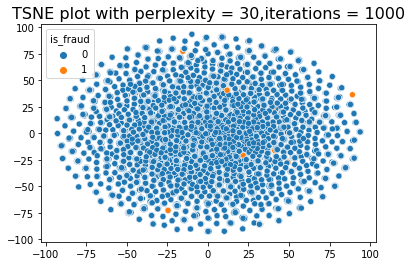

In [67]:
 # plot for tsne with perplexity = 30
ax = sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 30,iterations = 1000',fontsize = 16)


In [12]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=1000)
tsne_results_20_1000 = tsne.fit_transform(df_Test)

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000)
tsne_results_50_1000 = tsne.fit_transform(df_Test)

tsne = TSNE(n_components=2, verbose=1, perplexity=60, n_iter=1000)
tsne_results_60_1000 = tsne.fit_transform(df_Test)

tsne = TSNE(n_components=2, verbose=1, perplexity=50)
tsne_results_50 = tsne.fit_transform(df_Test)

tsne = TSNE(n_components=2, verbose=1, perplexity=60)
tsne_results_60 = tsne.fit_transform(df_Test)


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 27786 samples in 9.278s...
[t-SNE] Computed neighbors for 27786 samples in 2355.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27786
[t-SNE] Computed conditional probabilities for sample 2000 / 27786
[t-SNE] Computed conditional probabilities for sample 3000 / 27786
[t-SNE] Computed conditional probabilities for sample 4000 / 27786
[t-SNE] Computed conditional probabilities for sample 5000 / 27786
[t-SNE] Computed conditional probabilities for sample 6000 / 27786
[t-SNE] Computed conditional probabilities for sample 7000 / 27786
[t-SNE] Computed conditional probabilities for sample 8000 / 27786
[t-SNE] Computed conditional probabilities for sample 9000 / 27786
[t-SNE] Computed conditional probabilities for sample 10000 / 27786
[t-SNE] Computed conditional probabilities for sample 11000 / 27786
[t-SNE] Computed conditional probabilities for sample 12000 / 27786
[t-SNE] Computed conditional probabilities for 

[t-SNE] Computed conditional probabilities for sample 24000 / 27786
[t-SNE] Computed conditional probabilities for sample 25000 / 27786
[t-SNE] Computed conditional probabilities for sample 26000 / 27786
[t-SNE] Computed conditional probabilities for sample 27000 / 27786
[t-SNE] Computed conditional probabilities for sample 27786 / 27786
[t-SNE] Mean sigma: 14.777482
[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.281357
[t-SNE] KL divergence after 1000 iterations: 1.391024
[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 27786 samples in 9.492s...
[t-SNE] Computed neighbors for 27786 samples in 2394.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27786
[t-SNE] Computed conditional probabilities for sample 2000 / 27786
[t-SNE] Computed conditional probabilities for sample 3000 / 27786
[t-SNE] Computed conditional probabilities for sample 4000 / 27786
[t-SNE] Computed conditional probabilities for sample 5000 / 27786
[t-SNE] Compute

Text(0.5, 1.0, 'TSNE plot with perplexity = 20,iterations = 1000')

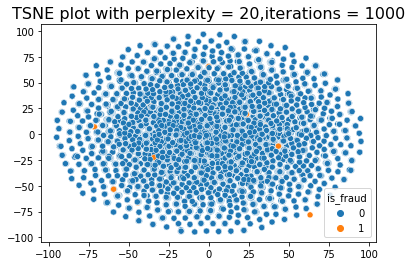

In [66]:
ax = sns.scatterplot(x=tsne_results_20_1000[:, 0], y=tsne_results_20_1000[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 20,iterations = 1000',fontsize = 16)

Text(0.5, 1.0, 'TSNE plot with perplexity = 50,iterations = 1000')

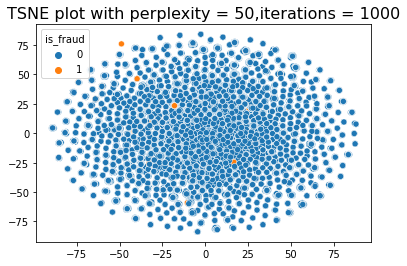

In [65]:
ax = sns.scatterplot(x=tsne_results_50_1000[:, 0], y=tsne_results_50_1000[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 50,iterations = 1000',fontsize = 16)

Text(0.5, 1.0, 'TSNE plot with perplexity = 60,iterations = 1000')

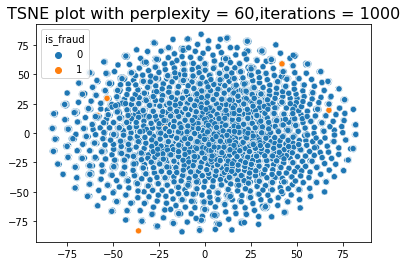

In [64]:
ax = sns.scatterplot(x=tsne_results_60_1000[:, 0], y=tsne_results_60_1000[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 60,iterations = 1000',fontsize = 16)

Text(0.5, 1.0, 'TSNE plot with perplexity = 50,iterations = max')

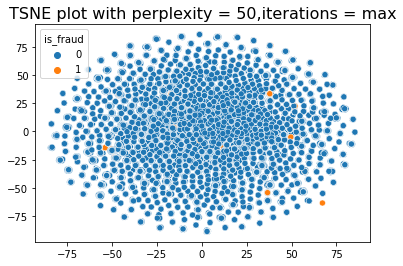

In [60]:
ax = sns.scatterplot(x=tsne_results_50[:, 0], y=tsne_results_50[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 50,iterations = max',fontsize = 16)

Text(0.5, 1.0, 'TSNE plot with perplexity = 60,iterations = max')

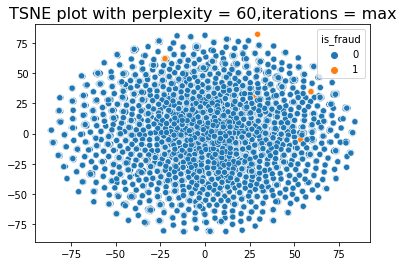

In [63]:
ax = sns.scatterplot(x=tsne_results_60[:, 0], y=tsne_results_60[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 60,iterations = max',fontsize = 16)

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 27786 samples in 9.370s...
[t-SNE] Computed neighbors for 27786 samples in 2345.323s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27786
[t-SNE] Computed conditional probabilities for sample 2000 / 27786
[t-SNE] Computed conditional probabilities for sample 3000 / 27786
[t-SNE] Computed conditional probabilities for sample 4000 / 27786
[t-SNE] Computed conditional probabilities for sample 5000 / 27786
[t-SNE] Computed conditional probabilities for sample 6000 / 27786
[t-SNE] Computed conditional probabilities for sample 7000 / 27786
[t-SNE] Computed conditional probabilities for sample 8000 / 27786
[t-SNE] Computed conditional probabilities for sample 9000 / 27786
[t-SNE] Computed conditional probabilities for sample 10000 / 27786
[t-SNE] Computed conditional probabilities for sample 11000 / 27786
[t-SNE] Computed conditional probabilities for sample 12000 / 27786
[t-SNE] Computed conditional probabilities for 

Text(0.5, 1.0, 'TSNE plot with perplexity = 70,iterations = 1000')

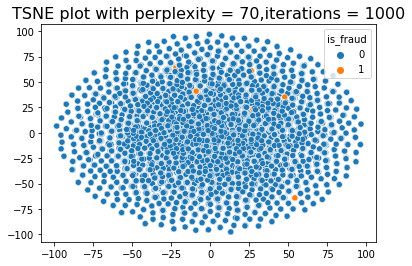

In [68]:
%%time
tsne_70 = TSNE(n_components=2, verbose=1, perplexity=70)
tsne_results_70 = tsne.fit_transform(df_Test)
ax = sns.scatterplot(x=tsne_results_70[:, 0], y=tsne_results_70[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 70,iterations = 1000',fontsize = 16)


In [ ]:
%%time
perp = [10,20,30,40,50,60,70,80]
fig = plt.figure(1,figsize =(20,11) )
s = len(perp)/3 +1
i=1
kl_div = []
for perpl in perp:
    tsne = TSNE(n_components=2, perplexity=perpl)
    tsne_results = tsne.fit_transform(df_Test)
    kl_div.append(tsne.kl_divergence_)
    plt.subplot(s,3,i)
    ax = sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1],hue = Y_test) 
    ax.set_title('TSNE plot with perplexity = 70,iterations = 1000',fontsize = 16)
    i+=1

In [ ]:
plt.plot(prep,kl_div)

Text(0.5, 1.0, 'TSNE plot with perplexity = 60,iterations = max')

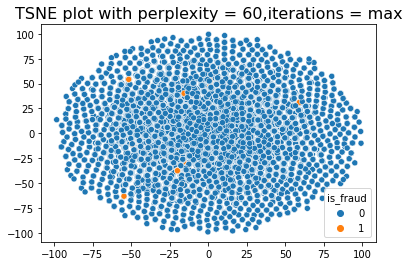

In [58]:
ax = sns.scatterplot(x=tsne_results_5[:, 0], y=tsne_results_5[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 60,iterations = max',fontsize = 16)

Text(0.5, 1.0, 'TSNE plot with perplexity = 60,iterations = max')

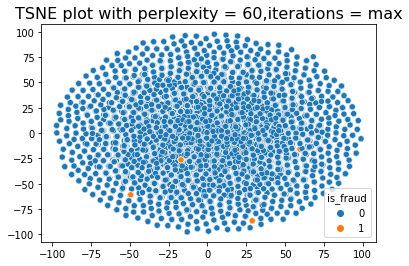

In [59]:
ax = sns.scatterplot(x=tsne_results_10[:, 0], y=tsne_results_10[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 60,iterations = max',fontsize = 16)

Text(0.5, 1.0, 'TSNE plot with perplexity = 60,iterations = max')

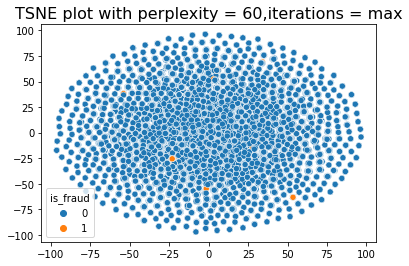

In [69]:
ax = sns.scatterplot(x=tsne_results_15[:, 0], y=tsne_results_15[:, 1],hue=Y_test) 
ax.set_title('TSNE plot with perplexity = 60,iterations = max',fontsize = 16)

In [ ]:
# ## to save and load tsne model
# np.save('tsne.npy', x_tsne_full) 
# np.load('tsne.npy')

In [ ]:
tsne_plot = [5,10,30,50,60]
[1.9,1.425989,1.1,1.391024,1.516109]

In [33]:
df_Train_copy = df_Train.copy()
df_Test_copy = df_Test.copy()

Types of Outliers   
Depending upon the feature space, outliers can be of two kinds: Univariate and Multivariate. The univariate outliers are the outliers generated by manipulating the value of a single feature. Univariate outliers are visible to the naked eye when plotted on one dimensional or two-dimensional feature space. The multivariate outliers are generated by manipulating values of multiple features.   

>- Local Outlier Factor (LOF) Was proposed by breunig et al, is an unsupervised anomaly detection
algorithm. In each point, it computes the density of its local neighborhood. One can recognize regions
of similar density, and points that have a substantially lower density than their neighbors. These are
considered to be outliers. LOF shares some concepts with OPTICS and DBSCAN which are used for
local density estimation such as the concepts of "reachability distance" and "core distance".   
Ad:Good algorithm for local
anomaly detection   
DisAd: 
  - Only relies on its direct neighborhood
  - Performs poorly on datasets with global anomalies
  - Scalability is a big issue  
- One-Class Support Vector (OCSVM) is an unsupervised anomaly detection algorithm. [13] It was
proposed by Scholkopf to identify anomaly without labeled training data. It is an application of
support vector machine algorithms to one class problems. This method separates by a hyperplane all
the data points from the origin. It estimates the density level sets and gives an estimate of underlying
density.
Ad: Finds the good separation hyperplane.Works well.
Dis ad: 
  - Not suitable for large amounts of datasets
  - Needs lots of memory
  - Some numerical stability problems
- K-means (KM) [14]is an unsupervised algorithm for anomaly detection. It divides data into K-clusters
and guarantees that the data in various clusters have low similarity, while the data within the same
cluster are similar. This clustering algorithm evaluates similarity and calculates the distance between
two samples. It is an efficient method to cluster the data.
Ad:
  - Easy to implement
  - Low complexity
Dis ad:
  - Sensitive to noise and outlier data points
  - Each cluster has pretty equal numbers of observations
  - Clusters are sensitive to initial assignment of centroids
  - Necessity of specifying K
  - Only work with numerical data
- Isolation Forest   
Ad: 
  - It needs small samples from large datasets so as to derive an anomaly detection function which makes it fast and
scalable.
  - It does not require example anomalies in the training dataset. 
  - The tree depth is the basis of its distance threshold for determining anomalies which is autonomous from the scaling of the dataset dimensions. 
  - It can both work as a supervised and an unsupervised classifier and its objective is that the anomalies are less recurrent than usual observations and vary from their values. 




reference : http://pen.ius.edu.ba/index.php/pen/article/view/533/312


   
### 5.  Considering the Fraud cases as anamoly and use anamoly detection methods such as:   
> 5.1 Simple Statistical Methods : Metrics such as distribution, including mean, median, mode, and quantiles could be used to identify outliers since the definition of an anomalous data point is one that deviates by a certain standard deviation from the mean.    
5.2 Density-Based Anomaly Detection : These include the    
 - 5.2.1 k-nearest neighbors algorithm   
 - 5.2.2 Relative density of data based method known as local outlier factor (LOF) algorithm **(Implemented)** 
 
>5.3 Isolation Forest **(Implemented)**   
5.4 Clustering-Based Anomaly Detection : K-means algorithm  **(Implemented)**
5.5 Support Vector Machine-Based Anomaly Detection          
5.6 Using Auto Encoders **(Implemented)**       
5.7 Neural Network  (Same as Autoencoders? ???)  
5.8 OneClassSVM    
5.9 DBSCAN    

### 5.1 Simple Statistical Methods 
Metrics such as distribution, including mean, median, mode, and quantiles could be used to identify outliers since the definition of an anomalous data point is one that deviates by a certain standard deviation from the mean. 


In [ ]:
# upper and lower limit calculation with z score method and handling out liers
#data = pd.read_csv('machine_0.csv',index_col=0)
def handle_outlier(data):
"""The function takes the data and replaces all the outlier values o f all columns
with '0000000001' """
data_outlier_handled = data.copy() 
column_names = data.columns 
total_outliers = []
for col in column_names:
t=0
upper_boundary = data_outlier_handled[col].mean() + 3 * data_out lier_handled[col].std()
lower_boundary = data_outlier_handled[col].mean() - 3 * data_out lier_handled[col].std()
data_outlier_handled.loc[data_outlier_handled[col] > upper_bound ary,col] = 0.0000000001
data_outlier_handled.loc[data_outlier_handled[col] < lower_bound ary,col] = 0.0000000001
tu = data[data[col] > upper_boundary].count()[1] tl = data[data[col] < lower_boundary].count()[1]
#total_outliers.append(round((tu+tl)/len(data),2)) #to calculate the percent of outliers handled
#print(total_outliers) #to print the percent of outliers handled
return data_outlier_handled

## -----------------------------------------------------------------------------------------------------------

### 5.2.1 K-nearest neighbour

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
%%time
df_Train, df_Test, Y_train, Y_test = getdatafiles()


(129668, 23) (27786, 23)
(129668, 13) (27786, 13)
(129668, 12) (129668,) (27786, 12) (27786,)
(129668, 12) (27786, 12)
merchant
category
gender
job
add
(129668, 2143) (27786, 2143)
0    128963
1       705
Name: is_fraud, dtype: int64 
 0    27656
1      130
Name: is_fraud, dtype: int64
(129668, 2143) (27786, 2143) (129668,) (27786,)
CPU times: user 11.7 s, sys: 2.35 s, total: 14.1 s
Wall time: 14.2 s


In [35]:

# files ready for testing on models
print(df_Train.shape, df_Test.shape, Y_train.shape, Y_test.shape)

(129668, 2143) (27786, 2143) (129668,) (27786,)


In [42]:
# # define standard scaler
# scaler = StandardScaler()
# # transform data
# df_Train = scaler.fit_transform(df_Train)
# df_Test = scaler.fit_transform(df_Test)


[[-0.32586742  1.70654084 -0.77092753 ... -0.0200296  -0.03558609
  -0.0339177 ]
 [ 1.39831264  1.59181149 -1.96202614 ... -0.0200296  -0.03558609
  -0.0339177 ]
 [-0.42305108 -2.08928604  0.57459753 ... -0.0200296  -0.03558609
  -0.0339177 ]
 ...
 [-0.28297122 -0.79463011 -0.16634395 ... -0.0200296  -0.03558609
  -0.0339177 ]
 [-0.41699745 -0.68614293  0.81380942 ... -0.0200296  -0.03558609
  -0.0339177 ]
 [-0.16508802  0.92135197  1.30174029 ... -0.0200296  -0.03558609
  -0.0339177 ]]


(129668, 2143)

In [90]:
%%time
# https://www.geeksforgeeks.org/ml-implementation-of-knn-classifier-using-sklearn/
K = [] 
training = [] 
test = [] 
scores = {} 
  
for k in range(2, 5): 
    clf = KNeighborsClassifier(n_neighbors = k) 
    clf.fit(df_Train, Y_train) 
  
    training_score = clf.score(df_Train, Y_train) 
    test_score = clf.score(df_Test, Y_test) 
    K.append(k) 
  
    training.append(training_score) 
    test.append(test_score) 
    scores[k] = [training_score, test_score]

CPU times: user 16min 16s, sys: 2min 20s, total: 18min 36s
Wall time: 20min 17s


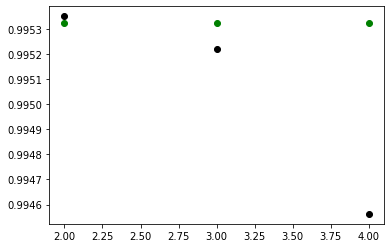

In [91]:
plt.scatter(K, training, color ='k') 
plt.scatter(K, test, color ='g') 
plt.show()

In [ ]:
# for pca
# https://datascienceplus.com/principal-component-analysis-pca-with-python/



In [43]:
%%time
# https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13
# instantiate model
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors = 10)
# fit model
nbrs.fit(df_Train)

CPU times: user 2min 26s, sys: 5.25 s, total: 2min 31s
Wall time: 2min 35s


NearestNeighbors(n_neighbors=10)

CPU times: user 3h 3min 57s, sys: 1min 28s, total: 3h 5min 25s
Wall time: 3h 7min 41s


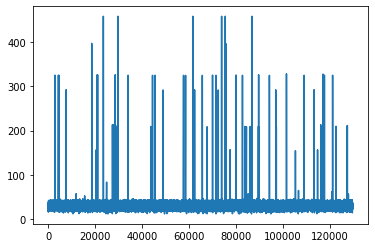

In [44]:
%%time
# distances and indexes of k-neaighbors from model outputs
distances, indexes = nbrs.kneighbors(df_Train)
# plot mean of k-distances of each observation
plt.plot(distances.mean(axis =1))

In [57]:
df_Train = pd.DataFrame(df_Train)
df_Test = pd.DataFrame(df_Test)

In [65]:

df_Train['distances'] = distances.mean(axis=1)
df_Train['is_fraud'] = df_Train['distances'].apply(lambda x:1 if x>35 else 0)
y_pred_knn = df_Train['is_fraud']
y_pred_knn.mean()

0.052572724187926086

In [66]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_pred_knn,Y_train))
print(classification_report(y_pred_knn,Y_train))

[[122256    595]
 [  6707    110]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    122851
           1       0.16      0.02      0.03      6817

    accuracy                           0.94    129668
   macro avg       0.55      0.51      0.50    129668
weighted avg       0.91      0.94      0.92    129668



###  5.2  Local Outlier Factor  
Density-Based Anomaly Detection : These include the k-nearest neighbors algorithm, Relative density of data based method known as local outlier factor (LOF) algorithm .    
The local outlier factor is based on a concept of a local density, where locality is given by k nearest neighbors, whose distance is used to estimate the density. By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. These are considered to be outliers.   

    

#### Acknowledgement
https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
    

In [67]:
df_Train, df_Test, Y_train, Y_test = getdatafiles()

(129668, 23) (27786, 23)
(129668, 13) (27786, 13)
(129668, 12) (129668,) (27786, 12) (27786,)
(129668, 12) (27786, 12)
merchant
category
gender
job
add
(129668, 2143) (27786, 2143)
0    128963
1       705
Name: is_fraud, dtype: int64 
 0    27656
1      130
Name: is_fraud, dtype: int64
(129668, 2143) (27786, 2143) (129668,) (27786,)


In [68]:
## Get the Fraud and the normal  transaction numbers for test and train dataset 

fraud_train = df_train[df_train['is_fraud']==1]
normal_train = df_train[df_train['is_fraud']==0]
fraud_test = df_test[df_test['is_fraud']==1]
normal_test = df_test[df_test['is_fraud']==0]

print("Normal cases in train set :",len(df_train)-len(fraud_train),"\nFraud cases in train set :",len(fraud_train))
print("Normal cases in test set :",len(df_test)-len(fraud_test),"\nFraud cases in test set :",len(fraud_test))
outlier_fraction = round(len(fraud_train)/len(df_train),4)
print("Fraud percentage :", outlier_fraction)
print("Fraud percentage :", len(fraud_test)/len(df_test))

Normal cases in train set : 128963 
Fraud cases in train set : 705
Normal cases in test set : 27656 
Fraud cases in test set : 130
Fraud percentage : 0.0054
Fraud percentage : 0.004678615129921543


In [69]:
# preprocssed files for our use
print(df_Train.shape, df_Test.shape, Y_train.shape, Y_test.shape)

(129668, 2143) (27786, 2143) (129668,) (27786,)


In [77]:
%%time
# train data set
a = LocalOutlierFactor(n_neighbors = 20,contamination = outlier_fraction)
y_prediction1 = a.fit_predict(df_Train) # Fitting the model.
y_prediction1[y_prediction1 == 1] = 0 # Valid transactions are labelled as 0.
y_prediction1[y_prediction1 == -1] = 1 # Fraudulent transactions are labelled as 1.
errors1 = (y_prediction1 != Y_train).sum() # Total number of errors is calculated.
print(errors1)
print(confusion_matrix(y_prediction1,Y_train))
print(accuracy_score(y_prediction1,Y_train))
print(classification_report(y_prediction1,Y_train))

1188
[[128371    596]
 [   592    109]]
0.9908381404818459
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128967
           1       0.15      0.16      0.16       701

    accuracy                           0.99    129668
   macro avg       0.58      0.58      0.58    129668
weighted avg       0.99      0.99      0.99    129668

CPU times: user 3min 10s, sys: 9.86 s, total: 3min 20s
Wall time: 3min 26s


In [75]:

from sklearn.metrics import roc_auc_score
roc_auc_score(Y_train, y_prediction1)

0.5650263754247398

In [76]:
%%time
# train data set
a = LocalOutlierFactor(n_neighbors = 15,contamination = outlier_fraction)
y_prediction1 = a.fit_predict(df_Train) # Fitting the model.
y_prediction1[y_prediction1 == 1] = 0 # Valid transactions are labelled as 0.
y_prediction1[y_prediction1 == -1] = 1 # Fraudulent transactions are labelled as 1.
errors1 = (y_prediction1 != Y_train).sum() # Total number of errors is calculated.
print(errors1)
print(confusion_matrix(y_prediction1,Y_train))
print(accuracy_score(y_prediction1,Y_train))
print(classification_report(y_prediction1,Y_train))

1194
[[128368    599]
 [   595    106]]
0.9907918684640775
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    128967
           1       0.15      0.15      0.15       701

    accuracy                           0.99    129668
   macro avg       0.57      0.57      0.57    129668
weighted avg       0.99      0.99      0.99    129668

CPU times: user 3min 3s, sys: 10.1 s, total: 3min 13s
Wall time: 3min 21s


In [72]:
%%time
# test data set

y_prediction1 = a.fit_predict(df_Test) # Fitting the model.
y_prediction1[y_prediction1 == 1] = 0 # Valid transactions are labelled as 0.
y_prediction1[y_prediction1 == -1] = 1 # Fraudulent transactions are labelled as 1.
errors1 = (y_prediction1 != Y_test).sum() # Total number of errors is calculated.
print(errors1)
print(accuracy_score(y_prediction1,Y_test))
print(classification_report(y_prediction1,Y_test))

267
0.9903908443100842
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     27635
           1       0.05      0.05      0.05       151

    accuracy                           0.99     27786
   macro avg       0.52      0.52      0.52     27786
weighted avg       0.99      0.99      0.99     27786

CPU times: user 37.2 s, sys: 784 ms, total: 38 s
Wall time: 38.2 s


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test, y_prediction1)

#### We see that Local Outlier Factor does not perform well as it gives Recall of 0.01 for both Test set and Train set.  
## -----------------------------------------------------------------------------------------------------------

## 5.3 Isolation Forest    
Isolation Forest is based on the Decision Tree algorithm. It isolates the outliers by randomly selecting a feature from the given set of features and then randomly selecting a split value between the max and min values of that feature. This random partitioning of features will produce shorter paths in trees for the anomalous data points, thus distinguishing them from the rest of the data.   


class sklearn.ensemble.IsolationForest(*, n_estimators=100, max_samples='auto', contamination='auto', max_features=1.0, bootstrap=False, n_jobs=None, behaviour='deprecated', random_state=None, verbose=0, warm_start=False)


#### Acknowledgement
https://medium.com/datadriveninvestor/credit-card-fraud-detection-using-local-outlier-factor-and-isolation-forest-in-python-56edd0a44af5
    

#### https://www.youtube.com/watch?v=TP3wdwD8JVY 

In [ ]:
df_Train, df_Test, Y_train, Y_test = getdatafiles()

In [14]:
# new data with zip as categorical variable
model_isolation_if3 = IsolationForest(max_samples = len(df_Train),contamination = outlier_fraction).fit(df_Train)

In [15]:
# predictions
y_pred_model_isolation_f3 = model_isolation_if3.predict(df_Train) # Prediction using trained model.
y_pred_model_isolation_f3[y_pred_model_isolation_f3 == 1] = 0 # Valid transactions are labelled as 0.
y_pred_model_isolation_f3[y_pred_model_isolation_f3 == -1] = 1 # Fraudulent transactions are labelled as 1.

In [20]:
# results 
errors_f3 = (y_pred_model_isolation_f3 != Y_train).sum() # Total number of errors is calculated.
print(errors_f3)
print(accuracy_score(Y_train,y_pred_model_isolation_f3))
print(classification_report(Y_train,y_pred_model_isolation_f3))
print(confusion_matrix(Y_train,y_pred_model_isolation_f3))
#print("roc_auc_score",roc_auc_score(Y_train,y_pred_model_isolation_f3))

1380
0.9893574359132554
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    128963
           1       0.02      0.02      0.02       705

    accuracy                           0.99    129668
   macro avg       0.51      0.51      0.51    129668
weighted avg       0.99      0.99      0.99    129668

[[128275    688]
 [   692     13]]


In [175]:
# train 
model_isolation_f1 = IsolationForest(max_samples = len(df_Train),contamination = outlier_fraction).fit(df_Train)

In [176]:
# predictions
y_pred_model_isolation_f1 = model_isolation_f1.predict(df_Train) # Prediction using trained model.
y_pred_model_isolation_f1[y_pred_model_isolation_f1 == 1] = 0 # Valid transactions are labelled as 0.
y_pred_model_isolation_f1[y_pred_model_isolation_f1 == -1] = 1 # Fraudulent transactions are labelled as 1.

In [183]:
# results 
errors_f1 = (y_pred_model_isolation_f1 != Y_train).sum() # Total number of errors is calculated.
print(errors_f1)
print(accuracy_score(Y_train,y_pred_model_isolation_f1))
print(classification_report(Y_train,y_pred_model_isolation_f1))
print("roc_auc_score",roc_auc_score(Y_train,y_pred_model_isolation_f1))

1390
0.9892803158836413
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    128963
           1       0.01      0.01      0.01       705

    accuracy                           0.99    129668
   macro avg       0.50      0.50      0.50    129668
weighted avg       0.99      0.99      0.99    129668

0.5029869417161434


In [184]:
model_isolation_f1.get_params(deep = True)

{'behaviour': 'deprecated',
 'bootstrap': False,
 'contamination': 0.0054,
 'max_features': 1.0,
 'max_samples': 129668,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [186]:
# train with different parameers
model_isolation_f2 = IsolationForest(random_state = 137).fit(df_Train)

In [187]:
model_isolation_f2.get_params(deep = True)

{'behaviour': 'deprecated',
 'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 'auto',
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 137,
 'verbose': 0,
 'warm_start': False}

In [188]:
# predictions
y_pred_model_isolation_f2 = model_isolation_f2.predict(df_Train) # Prediction using trained model.
y_pred_model_isolation_f2[y_pred_model_isolation_f2 == 1] = 0 # Valid transactions are labelled as 0.
y_pred_model_isolation_f2[y_pred_model_isolation_f2 == -1] = 1 # Fraudulent transactions are labelled as 1.

In [189]:
# results 
errors_f2 = (y_pred_model_isolation_f2 != Y_train).sum() # Total number of errors is calculated.
print(errors_f2)
print(accuracy_score(Y_train,y_pred_model_isolation_f2))
print(classification_report(Y_train,y_pred_model_isolation_f2))
print("roc_auc_score",roc_auc_score(Y_train,y_pred_model_isolation_f2))

705
0.9945630379122066
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    128963
           1       0.00      0.00      0.00       705

    accuracy                           0.99    129668
   macro avg       0.50      0.50      0.50    129668
weighted avg       0.99      0.99      0.99    129668

roc_auc_score 0.5


In [192]:
print(confusion_matrix(Y_train,y_pred_model_isolation_f2))

[[128963      0]
 [   705      0]]


### 5.4 kmeans algorithm 

In [145]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=137, n_jobs=-1).fit(df_Train)

/Users/sapnasharma/miniconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [146]:
X_test_clusters=kmeans.predict(df_Test)
X_test_clusters_centers=kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(df_Test.values,X_test_clusters_centers[X_test_clusters])]

km_y_pred=np.array(dist)
km_y_pred[dist>=np.percentile(dist,95)]=1
km_y_pred[dist<np.percentile(dist,95)]=0

In [148]:
roc_auc_score(Y_test,km_y_pred)

0.47486982933179056

## 5.6 Implementing Autoencoder to detect the fraud cases


#### Acknowledgemet:
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd (Venelin Vankov)    
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/blob/master/fraud_detection.ipynb    

https://www.youtube.com/watch?v=S31E-ftRfQI    

https://github.com/dpanagop/ML_and_AI_examples/blob/master/Credit_Fraud_detection_with_autoencoders.ipynb  (not used)   
https://www.youtube.com/watch?v=S31E-ftRfQI  (refernce)  

       

In [78]:
# preprocessing 


df_Train_copy = df_Train_copy.drop(['unix_time'], axis=1)
df_Test_copy = df_Test_copy.drop(['unix_time'], axis=1)

df_Train_copy['amt'] = StandardScaler().fit_transform(df_Train_copy['amt'].values.reshape(-1, 1))
df_Test_copy['amt'] = StandardScaler().fit_transform(df_Test_copy['amt'].values.reshape(-1, 1))

In [79]:
df_Train_copy.shape,df_Test_copy.shape

((129668, 3076), (27786, 3076))

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [80]:
# building the model
input_dim = df_Train_copy.shape[1]

encoding_dim = 14

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [82]:
nb_epoch = 100
batch_size = 32
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(df_Train_copy, df_Train_copy,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(df_Test_copy, df_Test_copy),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
4053/4053 [==============================] - 12s 3ms/step - loss: 33123092.0000 - accuracy: 0.7762 - val_loss: 35099472.0000 - val_accuracy: 0.7910
Epoch 2/100
4053/4053 [==============================] - 9s 2ms/step - loss: 33120408.0000 - accuracy: 0.7910 - val_loss: 35096760.0000 - val_accuracy: 0.7910
Epoch 3/100
4053/4053 [==============================] - 11s 3ms/step - loss: 33117814.0000 - accuracy: 0.7910 - val_loss: 35094080.0000 - val_accuracy: 0.7910
Epoch 4/100
4053/4053 [==============================] - 12s 3ms/step - loss: 33115254.0000 - accuracy: 0.7910 - val_loss: 35091440.0000 - val_accuracy: 0.7910
Epoch 5/100
4053/4053 [==============================] - 10s 3ms/step - loss: 33112558.0000 - accuracy: 0.7910 - val_loss: 35088764.0000 - val_accuracy: 0.7910
Epoch 6/100
4053/4053 [==============================] - 10s 3ms/step - loss: 33109974.0000 - accuracy: 0.7910 - val_loss: 35086112.0000 - val_accuracy: 0.7910
Epoch 7/100
4053/4053 [==================

In [83]:
# loading the saved model
autoencoder = load_model('model.h5')


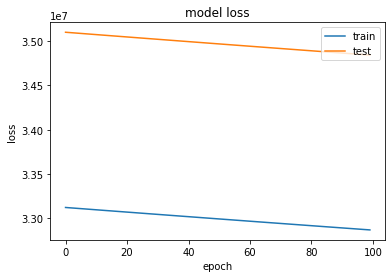

In [84]:
#evaluations
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [85]:
predictions = autoencoder.predict(df_Test_copy)

mse = np.mean(np.power(df_Test_copy - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_test})
error_df.describe()

,reconstruction_error,true_class
count,2.778600e+04,27786.000000
mean,3.484177e+07,0.004679
std,2.099092e+08,0.068241
min,1.075042e+02,0.000000
25%,2.517275e+05,0.000000
50%,9.768356e+05,0.000000
75%,2.151963e+06,0.000000
max,2.743262e+09,1.000000


In order to predict whether or not a new/unseen transaction is normal or fraudulent, we’ll calculate the reconstruction error from the transaction data itself.   
If the error is larger than a predefined threshold, we’ll mark it as a fraud (since our model should have a low error on normal transactions).   
Picking a value as .004 times the mean .( Chosen empirically)

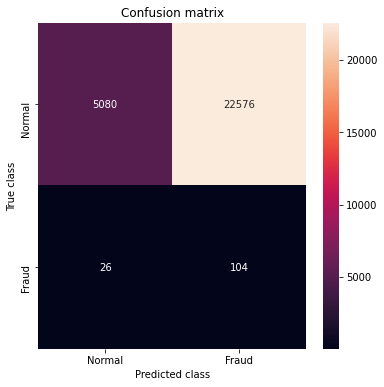

In [110]:
# predictions
threshold = (3.484177e+07)*.004


LABELS = ["Normal", "Fraud"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [111]:
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.18      0.31     27656
           1       0.00      0.80      0.01       130

    accuracy                           0.19     27786
   macro avg       0.50      0.49      0.16     27786
weighted avg       0.99      0.19      0.31     27786



## Observation 
### Not effective 
The model is predicting the fraud with a recall of 80% , but at the same time it is classifying 22576 cases as fraud which were not fraud.

### 5.7 Neural Network  (Same as Autoencoders? ???) 

### 5.8 OneClassSVM    

Class sklearn.svm.OneClassSVM(*, kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=-1)



In [ ]:
from sklearn.svm import OneClassSVM
model_oneclassSVM1 = OneClassSVM(gamma='auto',n_jobs = -1).fit(df_Train)

In [ ]:
# predictions
y_pred_model_oneclassSVM1 = model_oneclassSVM1.predict(df_Train) # Prediction using trained model.
y_pred_model_oneclassSVM1[y_pred_model_oneclassSVM1 == 1] = 0 # Valid transactions are labelled as 0.
y_pred_model_oneclassSVM1[y_pred_model_oneclassSVM1 == -1] = 1 # Fraudulent transactions are labelled as 1.

In [ ]:
# results 
errors_oneclassSVM1 = (y_pred_model_oneclassSVM1 != Y_train).sum() # Total number of errors is calculated.
print(errors_oneclassSVM1)
print(accuracy_score(Y_train,y_pred_model_oneclassSVM1))
print(classification_report(Y_train,y_pred_model_oneclassSVM1))
print("roc_auc_score",roc_auc_score(Y_train,y_pred_model_oneclassSVM1))